# Homework 07

### Preparation...

Run this code from the lecture to be ready for the exercises below!

In [18]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

In [2]:
CONFIG_FILE = './entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [3]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(download_dir)

Concatenating 68 csv files...
Loading done.


In [4]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate()
    #ret_data = ret_data.set_index("DateTime")
    ret_data = ret_data.resample("1h").mean().interpolate()
    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2015-01-01":"2019-12-31"]

## Exercise 1

Explain the following terms:

**Input feature:** machine learning algorithms need input data to create an output. This input data needs to have speacial features - usually structured columns - in order to work. 

**Output feature:** you can train machine learning algorithms with input data in order to create predictions. these predictions are called output. 

**Fit a function to data:** data consists of discreet values. To make a prediction, we want to create a function, so we can input an arbitrary future date and predict. Fitting a function is the process of decreasing the error between the function that approximates the datapoints and the datapoints themselves.

**Training data:** data that helps the algorithm to predict the outcome

**Test data:** data that will help the user to see if the algorithm predicts correctly. the basic rule is 80% training data, 20% testing data from your data set. 


    

## Exercise 2

In lecture07 we created a plot of the ratio of actual load and predicted load for Austria step by step (Exercise 04). Now put all of this together in one function which takes one parameter `country` as input and calculates and plots the figure of Exercise 04 for this country! The model should be trained on 2015-2019 data and then you should predict for 2020 and compare it to observations. Also do a training/test split and print the R2 for both datasets.

Apply the function to the following countries and show the results in one plot: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(1) Print the country name. Get the data for the specific country using get_hourly_country_data from the lecture and extract two periods, i.e 2015-2019 and 2020 in two separate dataframes.

(2) Define X (the input features, i.e. the indicators for time) and Y (i.e. the output feature, the electricity load). Observe that for training, we use the period 2015-2019.

(3) Do a train/test split

(4) Fit the input features to the output feature using a ```RandomForestRegressor```

(5) Predict the output with the training data and the test data and compute the R^2 for both!

(6) Print the R^2.

(7) Create a new variable ```X_2020``` which contains the input features for the year 2020.

(8) Predict with your model the load for 2020.

(9) Assign your prediction back to the dataframe in a new column and calculate the monthly mean for prediction and for observed load. You might need to copy the dataframe first by doing something like `power_demand_hourly = power_demand_hourly.copy()` (otherwise it might be just a slice of the complete time range and then you can't add a column for some rows only).

(10) Plot the ratio of load and prediction. With ```label=country```, you can add a label to your plot for making a legend.

(11) Execute the function for the following countries: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(12) After calling the functions, use ```plt.legend()``` to show a legend.

Country name: Austria
Period 1 r2 score test:  0.8294793414795285
Period 1 r2 score training:  0.8441846088331973
Country name: Germany
Period 1 r2 score test:  0.8847746083953704
Period 1 r2 score training:  0.8858446198744911
Country name: Switzerland
Period 1 r2 score test:  0.6384532815943642
Period 1 r2 score training:  0.664796519620709
Country name: Italy
Period 1 r2 score test:  0.8426541690061254
Period 1 r2 score training:  0.8612228185669872
Country name: Spain
Period 1 r2 score test:  0.8348691128211834
Period 1 r2 score training:  0.8710142816348845
Country name: Sweden
Period 1 r2 score test:  0.8327011267407192
Period 1 r2 score training:  0.8627758943842865
Country name: United Kingdom
Period 1 r2 score test:  0.6947334293630847
Period 1 r2 score training:  0.7252248815878022


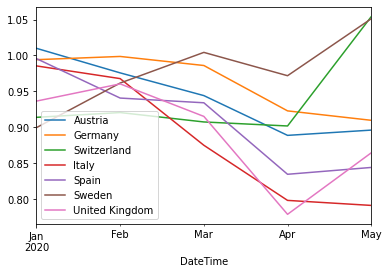

In [12]:
def plot_ratio_for_country(country):
    # (1)
    print('Country name: ' + country)
        
    power_demand_hourly_period1 = get_hourly_country_data(power_demand, country)["2015-01-01" : "2019-12-31"]
    power_demand_hourly_period2 = get_hourly_country_data(power_demand, country)["2020-01-01" : "2020-12-31"]

    # (2)
    X = np.array([power_demand_hourly_period1.index.month.values, power_demand_hourly_period1.index.weekday.values, power_demand_hourly_period1.index.hour.values]).T
    Y = power_demand_hourly_period1["TotalLoadValue"].values
    
    model = ensemble.RandomForestRegressor()
    
    # (3)
    X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2)
    
    # (4)
    model.fit(X_training, Y_training)
    
    # (5)
    prediction_test = model.predict(X_test)
    prediction_training = model.predict(X_training)
    
    r2_score_test = r2_score(Y_test, prediction_test)
    r2_score_training = r2_score(Y_training, prediction_training)
    
    # (6)
    print('Period 1 r2 score test: ', r2_score_test)
    print('Period 1 r2 score training: ', r2_score_training)
    
    # (7)
    X_2020 = np.array([power_demand_hourly_period2.index.month.values, power_demand_hourly_period2.index.weekday.values, power_demand_hourly_period2.index.hour.values]).T
    
    # (8)
    prediction_2020 = model.predict(X_2020)
    
    # (9)
    # We assign the hourly ratio back, not the average, since the assingment reads 'power_demand_hourly = power_demand_hourly.copy()'
    power_demand_hourly_period2['pred_2020'] = power_demand_hourly_period2['TotalLoadValue'].values/prediction_2020
    
    # (10)
    plot = power_demand_hourly_period2.resample('1m').mean()['pred_2020'].plot()
    plt.legend(countries)
    
countries = ['Austria', 'Germany', 'Switzerland', 'Italy', 'Spain', 'Sweden', 'United Kingdom']
    
for country in countries:
    plot_ratio_for_country(country)

## Exercise 3
Answer the following questions:

(1) Which country had the strongest decline in electricity consumption?

Without looking at the mean over the whole period, it seems that Italy, UK, and Spain have the biggest divergence from our expected consumption.

(2) For which country does the fit work best?

Germany, because we have the highest r2 value for both the test and training set.

(3) Where is the difference of R2 between training data and test data the largest? What does that mean?

Spain has the highest difference. That means that we might have overfitted the model, since we do better on the training set than on the test set.

(4) Look into the data of the country with the largest difference in the R2 of the training and the test data. Can you explain what is happening there? Might this effect our model?

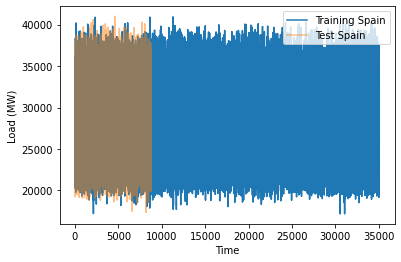

In [21]:
power_demand_hourly_period1_spain = get_hourly_country_data(power_demand, 'Spain')["2015-01-01" : "2019-12-31"]
power_demand_hourly_period2_spain = get_hourly_country_data(power_demand, 'Spain')["2020-01-01" : "2020-12-31"]

X_spain = np.array([power_demand_hourly_period1_spain.index.month.values, power_demand_hourly_period1_spain.index.weekday.values, power_demand_hourly_period1_spain.index.hour.values]).T
Y_spain = power_demand_hourly_period1_spain["TotalLoadValue"].values

model = ensemble.RandomForestRegressor()

X_training_spain, X_test_spain, Y_training_spain, Y_test_spain = train_test_split(X_spain, Y_spain, test_size=0.2)

plt.plot(Y_training_spain, label="Training Spain")
plt.plot(Y_test_spain, label="Test Spain", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()

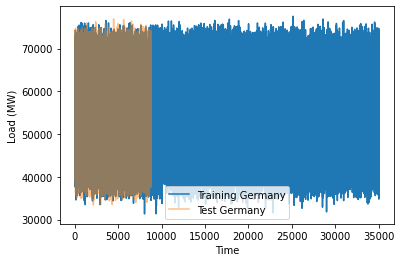

In [23]:
power_demand_hourly_period1_germany = get_hourly_country_data(power_demand, 'Germany')["2015-01-01" : "2019-12-31"]
power_demand_hourly_period2_germany = get_hourly_country_data(power_demand, 'Germany')["2020-01-01" : "2020-12-31"]

X_germany = np.array([power_demand_hourly_period1_germany.index.month.values, power_demand_hourly_period1_germany.index.weekday.values, power_demand_hourly_period1_germany.index.hour.values]).T
                      
model = ensemble.RandomForestRegressor()

X_training_germany, X_test_germany, Y_training_germany, Y_test_germany = train_test_split(X_germany, Y_germany, test_size=0.2)
                      
plt.plot(Y_training_germany, label="Training Germany")
plt.plot(Y_test_germany, label="Test Germany", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()

As we can see in the plots above, the test data set seems to vary with a higher degree for Spain than it does for Germany. Due to that fact, it makes sense that the model has more difficulty predicting for the Spain's test set.

## Exercise 4

The difference between model prediction and actual observation may help understanding how people behaved during the lockdown. In this exercise, you should come up with your own hypothesis of how people behaved and how this affected power consumption. You may, e.g., look into demand on different weekdays or in different hours. Once you have a hypothesis and a theory, why this hypothesis may be valid, test it with the model: is your hypothesis covered by what you observe in the load data?

Hypothesis: during lockdown, people rather do online activities because they can't meet (e.g. Netflix). Therefore the powerconsumption in the evening hours actually increased.

Period 1 r2 score test:  0.8323949953465842
Period 1 r2 score training:  0.8437147096530475


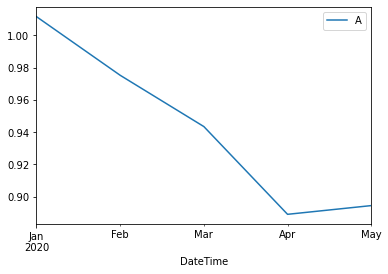

In [39]:
def check_evening_consumption():
    power_demand_at_hourly_evening_p1 = power_demand_at_hourly.copy()
    power_demand_at_hourly_evening_p1.drop(power_demand_at_hourly_evening_p1.between_time("00:00", "19:59").index)

    power_demand_at_hourly_evening_p2 = get_hourly_country_data(power_demand, "Austria")["2020-01-01":"2020-12-31"]
    power_demand_at_hourly_evening_p2.drop(power_demand_at_hourly_evening_p2.between_time("00:00", "19:59").index)

    X = np.array([power_demand_at_hourly_evening_p1.index.month.values, power_demand_at_hourly_evening_p1.index.weekday.values, power_demand_at_hourly_evening_p1.index.hour.values]).T
    Y = power_demand_at_hourly_evening_p1["TotalLoadValue"].values

    model = ensemble.RandomForestRegressor()

    X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2)

    model.fit(X_training, Y_training)

    prediction_test = model.predict(X_test)
    prediction_training = model.predict(X_training)

    r2_score_test = r2_score(Y_test, prediction_test)
    r2_score_training = r2_score(Y_training, prediction_training)

    print('Period 1 r2 score test: ', r2_score_test)
    print('Period 1 r2 score training: ', r2_score_training)

    X_2020 = np.array([power_demand_at_hourly_evening_p2.index.month.values, power_demand_at_hourly_evening_p2.index.weekday.values, power_demand_at_hourly_evening_p2.index.hour.values]).T

    prediction_2020 = model.predict(X_2020)

    power_demand_at_hourly_evening_p2['pred_2020'] = power_demand_at_hourly_evening_p2['TotalLoadValue'].values/prediction_2020

    plot = power_demand_at_hourly_evening_p2.resample('1m').mean()['pred_2020'].plot()
    plt.legend('Austria')
    
check_evening_consumption()

Result: still less consumption than predicted :( let's hope people read books instead.

## Exercise 5

Download ERA5 temperature data for the next lecture.

First install necessary dependencies `xarray` and `cdsapi`:

In [5]:
conda install --yes xarray

Solving environment: done

## Package Plan ##

  environment location: /home/lukas/miniconda3

  added / updated specs:
    - xarray


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    xarray-0.15.1              |             py_0         460 KB
    ------------------------------------------------------------
                                           Total:         460 KB

The following NEW packages will be INSTALLED:

  xarray             pkgs/main/noarch::xarray-0.15.1-py_0



xarray-0.15.1        | 460 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [6]:
conda install --yes -c conda-forge cdsapi

Solving environment: done

## Package Plan ##

  environment location: /home/lukas/miniconda3

  added / updated specs:
    - cdsapi


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cdsapi-0.2.7               |             py_0          14 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          14 KB

The following NEW packages will be INSTALLED:

  cdsapi             conda-forge/noarch::cdsapi-0.2.7-py_0

The following packages will be UPDATED:

  ca-certificates     pkgs/main::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0
  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi              pkgs/main::certifi-2020.4.5.1-py37_0 --> conda-f

The [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) provides [reanalysis climate data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20))). We are going to download [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form) data and use the [temperature 2m above ground values](https://apps.ecmwf.int/codes/grib/param-db?id=167).

Register for the CDS API and install the API key by following [this guide](https://cds.climate.copernicus.eu/api-how-to). You don't need to run `pip install cdsapi`, this has been done in the cell above already using conda.

In [4]:
import cdsapi

c = cdsapi.Client()

In [19]:
# Add the path to the lecture repository here:
PATH_TO_LECTURE_REPO = '../..'

if not os.path.isdir(Path(PATH_TO_LECTURE_REPO) / 'lecture00-introduction'):
    raise RuntimeError(f"Wrong path to lecture repository: PATH_TO_LECTURE_REPO = {PATH_TO_LECTURE_REPO}")

We'll download data from 2015 to 2020 in a bounding box which covers all countries we used so far for our analysis.
To make the download a bit faster, we'll use a [0.5° grid](https://confluence.ecmwf.int/display/CKB/ERA5%3A+Web+API+to+CDS+API) instead of the 0.1° grid. This will download approximately 500MB. The download might take a couple of hours, because the data is prepared on their servers before it can be downloaded.

In [12]:
filename = Path(PATH_TO_LECTURE_REPO) / 'data' / 'temperatures_era5.nc'

north, west, south, east = 70.,-13.5, 35.5, 24.5

c.retrieve(
    'reanalysis-era5-land',
    {
        'format': 'netcdf',
        'variable': '2m_temperature',
        'area': [
            north, west, south, east
        ],
        'grid': [0.5, 0.5],  # grid in 0.5deg steps in longitude/latitude
        'day': [f"{day:02d}" for day in range(1, 32)],
        'time': [f"{hour:02d}:00" for hour in range(24)],
        'month': [f"{month:02d}" for month in range(1, 13)],
        'year': [str(year) for year in range(2015, 2021)],
    },
    f"{filename}.part")

# this prevents you from accidentally using broken files:
os.rename(f"{filename}.part", filename)

2020-06-03 14:58:12,973 INFO Welcome to the CDS
2020-06-03 14:58:12,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2020-06-03 14:58:13,665 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data2/adaptor.mars.internal-1591183051.143155-14109-29-85466677-b2b7-422c-8304-0a46d57630dc.nc to /mnt/c/Users/Lukas/Desktop/Herzblatt/data/temperatures_era5.nc.part (473.2M)
2020-06-03 15:00:44,325 INFO Download rate 3.1M/s   


## Exercise 6

Load the file downloaded in exercise 3 and plot the temperature for one location. This is also a test if the download was successful. To load the file import the library `xarray`. Typically it is imported by using `import xarray as xr`. Then load the file using the command `xr.load_dataset(filename)`. Check the type of the return value. Then select the data variable `t2m` (temperature at 2m), select the values for `longitude=16.5` and `latitude=48` by using `temperatures_dataset.t2m.sel(longitude=16.5, latitude=48.)`. Then plot the result by calling `.plot()` on the resulting object.

Does the result look reasonable?

In [14]:
import xarray as xr

dataset = xr.load_dataset(filename)

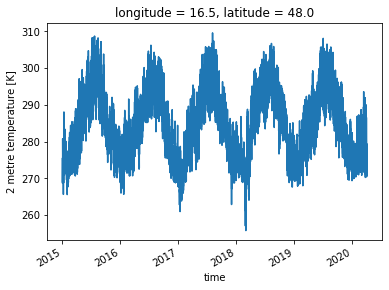

In [22]:
dataset.t2m.sel(longitude=16.5, latitude=48.).plot()

Data looks reasonable for temparatures throughout the year around Vienna.